# This notebook documents my process to develop ML models for detecting fraudulent transactions based on the data I have engineered in the previous step

<h1>Update after testing on the test dataset:</h1>

*Please see notebook model_development_dev_phase.ipynb for the results I obtained while knowing on the development data.*

After the changes in the feature engineering phase, I can see the performance of LR degrades significantly and DT decreases a little bit. However, the performance of XGBoosting is still the same (of course, with some enhancement in the training process).

<h1>Summary:</h1>

- As I have explained in the EDA and feature engineering step, the data we are using is very skewed. Then, I thought of doing some data oversampling/undersampling strategies. Specifically, I tried SMOTE, which increases minority class (in this case, fraudulent transactions). I do not think it is a good idea to perform undersampling as the number of fraudulent samples is too small (97).

- I splitted the development data to 7/3, meaning that 30% of the data is reserved for test. To ensure fair evaluation, I test all models (listed below) on the same test data.
  
- The data is labelled. Natually, we can think of supervised techniques. However, I would like to see the performance of unsupervised and semi-supervised learning models. In short:
  + For supervised learning models, I tried Logistic Regression (LR), Decision Tree (DT), and XGBoosting (XGB). Those models perform very well, with almost perfect score! You will see later that LR and XGB have only 1 false negative and 0 false postive. DT is a bit worse than those, but it is still impressive with 1 false negative and 2 false positives. A note, in those models, I did not play with hyperparameters too much, but still got very good results! A major problem with supervised learning models is we need labelled data, which is sometimes not easy to obtain (not sure for the case with Vipps MobilePay).
  + To address that problem, we can try unsupervised and semi-supervised learning models.
  + For unsupervised learning models, I tried KMeans, IsolationForest (IF) and GaussianMixture (GM). They are popular models for anomaly detection and they totally do not need any label. However, the performance is very bad, but I can still report in anyway so that we can have some more points to discuss.
  + For semi-supervised learning models, I tried AutoEncoder (AE). I would say doing deep learning may be overkilling, but why not give it a try. A major problem with is there are many hyperparameters to optimize like weights, number of layers, etc.

- As you will see below, the false negative install that LR, DT, and XGB made have pretty small impact to the system, so I think the process can be decleared as done. In terms of performance, I come with the following: supervised > semi-supervised > unsupervised. Of course, it comes with a major trade-off - labelling the data.

- In this work, I want to focus on models that I have high interpretability as we should deal with GDPR. Everything must be clearly explained to customers.

- I have been talking about performance and I mean accuracy. As I explain in the EDA part, here is my motivation. Distinguishing fraud and non-fraud transactions is basically a binary classification problem. There are a few we can think of the following: F1, AUC-ROC, or AUC-PR. I prefer to use AUC-PR and below are some reasonsings:
   + F1: this can give good scores to ML models even if anomalies are missed and we don't want it! In addition, it's senstive to thresholds. A small change in the threshold can result in significant difference. It's sometimes difficult to come up with a reasonable threshold and we have to frequently adjust thresholds due to concept drift (i.e., unexpected data distribution changes - one of my ML project is about this [3]).
   + AUC-ROC: although this metric is independent from thresholds (see F1). A major drawback of AUC-ROC is it can give good scores to ML models that have high TNR (True Negative Rate) and low TPR (True Positive Rate). *We clearly don't want it because we want to identify as many positives (fraud transactions) as possible!*
   + AUC-PR: same to AUC-ROC, this is independent from thresholds (+1). In addition, it focuses on positive class (in our case, fraud transactions).
   + For more details, you can look at [3] ([2] can be a good resource).

References:

[1] Wu, R. and Keogh, E.J., 2021. Current time series anomaly detection benchmarks are flawed and are creating the illusion of progress. IEEE transactions on knowledge and data engineering, 35(3), pp.2421-2429. https://arxiv.org/pdf/2009.13807 

[2] Sebastian Schmidl, Phillip Wenig, and Thorsten Papenbrock. Anomaly Detection in Time Series: A Comprehensive Evaluation. PVLDB, 15(9): 1779 - 1797, 2022. doi:10.14778/3538598.3538602. https://dl.acm.org/doi/10.14778/3538598.3538602 

[3] Nguyen, N.T., Heldal, R. and Pelliccione, P., 2024. Concept-drift-adaptive anomaly detector for marine sensor data streams. Internet of Things, p.101414. https://www.sciencedirect.com/science/article/pii/S254266052400355X

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

## Load the feature-engineered data and perform sampling

In [2]:
import pandas as pd
import numpy as np
import metrics
import utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import pickle

In [3]:
path_to_data_dev = 'assets/data4dev.csv'
path_to_data_orig = 'assets/orig_data.csv'
test_size = 0.3
seed = 42

In [4]:
df = pd.read_csv(path_to_data_dev, index_col=None)
df = df.fillna(0)
df

,id,amount,status,flowname,bankfees,sender_age,receiver_age,fraud,amount_outlier,amount_zscore,...,transaction_frequency,transaction_time_diff,hour,weekday,day,is_pension,pensionpaid_transaction_days_diff,sender_total_failed_transactions,seconds_diff_last_failed,flow_fraud_rate
0,5c8151de80789d810adffd2ad6c6d73e,11.0,1,5,0.0,15,15,0,0,-0.302760,...,0,0.000000,7,0,13,0,0,0,0,0.000000
1,90b30bc7689ac1b1f01fc1b76b241e17,200.0,1,2,0.0,18,26,0,0,-0.125919,...,0,0.000000,7,0,13,0,0,0,0,0.000127
2,e47bcec76ce7fdfb495ccee208faf714,136.0,1,9,0.0,44,41,0,0,-0.185802,...,0,0.000000,7,0,13,0,0,0,0,0.000334
3,3468a6acbf03452cf1725ffc5cb53cab,190.0,1,2,0.0,38,38,0,0,-0.135276,...,0,0.000000,7,0,13,0,0,0,0,0.000127
4,eb7027331b7324db8635e364ea8ff934,16.0,1,5,0.0,17,18,0,0,-0.298082,...,0,0.000000,7,0,13,0,0,0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1570038,de8efe7c02d565efbf6a3e1ba966a568,4600.0,1,2,0.0,77,42,1,1,3.991020,...,5,57.635233,19,0,24,1,34,0,0,0.000127
1570039,b4a3679623887aa236fe69567daf6d27,4600.0,1,2,0.0,77,42,1,1,3.991020,...,6,73.285683,19,0,24,1,34,0,0,0.000127
1570040,deca5e00cdfe11de14b4558b7b019956,4600.0,1,2,0.0,77,42,1,1,3.991020,...,7,179.864970,19,0,24,1,34,0,0,0.000127
1570041,49f3f8fb4b9720a08c5c57940487c6fd,4600.0,1,2,0.0,77,42,1,1,3.991020,...,8,32.605414,19,0,24,1,34,0,0,0.000127


In [5]:
df.columns

Index(['id', 'amount', 'status', 'flowname', 'bankfees', 'sender_age',
       'receiver_age', 'fraud', 'amount_outlier', 'amount_zscore',
       'sender_age_zscore', 'receiver_age_zscore', 'amount_zscore_sender_age',
       'amount_zscore_receiver_age', 'bankfees_zscore_sender_age',
       'bankfees_zscore_receiver_age', 'fee_per_transaction',
       'sender_age_zscore_receiver_age', 'age_diff_sender_receiver',
       'transaction_frequency', 'transaction_time_diff', 'hour', 'weekday',
       'day', 'is_pension', 'pensionpaid_transaction_days_diff',
       'sender_total_failed_transactions', 'seconds_diff_last_failed',
       'flow_fraud_rate'],
      dtype='object')

In [6]:
# Split data for test
target = 'fraud'
index = 'id'
X = df.drop(columns=[target, index], axis=1)  
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=seed)

In [7]:
# Standardize features
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.transform(X_test)

# store scaler for inference on test data
utils.save_scaler(scaler, 'assets/data_scaler.pkl')

In [8]:
# Balance the data using SMOTE
smote = SMOTE(random_state=seed)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_standardized, y_train)

# store scaler for inference on test data
utils.save_scaler(smote, 'assets/smote_scaler.pkl')

## Logistics Regression

In [9]:
model_name = 'lr'

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Train model
clf = LogisticRegression(class_weight=class_weights_dict, random_state=seed)
clf.fit(X_train_balanced, y_train_balanced)

LogisticRegression(class_weight={0: 0.5000309382854002, 1: 8081.10294117647},
                   random_state=42)

F1: 0.002338888192791213
AUC ROC : 0.9574010713886174
AUC PR: 0.0011326107795042867
Sensitivity (Recall): 0.9655172413793104
Specificity: 0.9492849013979243


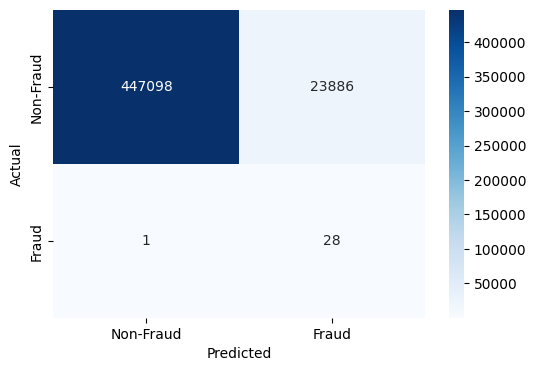

array([[447098,  23886],
       [     1,     28]])

In [11]:
# Evaluate model
y_pred = clf.predict(X_test_standardized)
print("F1:", metrics.calc_f1(y_test, y_pred))
print("AUC ROC :", metrics.calc_auc_roc(y_test, y_pred))
print("AUC PR:", metrics.calc_auc_pr(y_test, y_pred))
print("Sensitivity (Recall):", metrics.calc_sensitivity(y_test, y_pred)) 
print("Specificity:", metrics.calc_specificity(y_test, y_pred))
metrics.generate_confusion_matrix(y_test, y_pred, 'results/' + model_name + '_confusion_matrix.png')

As you see, LR only has 1 false negative and 0 false positive. 

I am a bit worried if the model is overfitting, so I perform k-fold cross validation and the result is consistent. 
It is also confirmed by impressive results of other models - see later. 

*Update after test:*

The performance of LR degrades significantly after I performed new feature engineering process. Given the fact that LR now is worse than DT, I would say that my features are now not linear anymore. However, you will see that LR is still much better than unsupervised learning and AutoEncoder (semi-supervised).

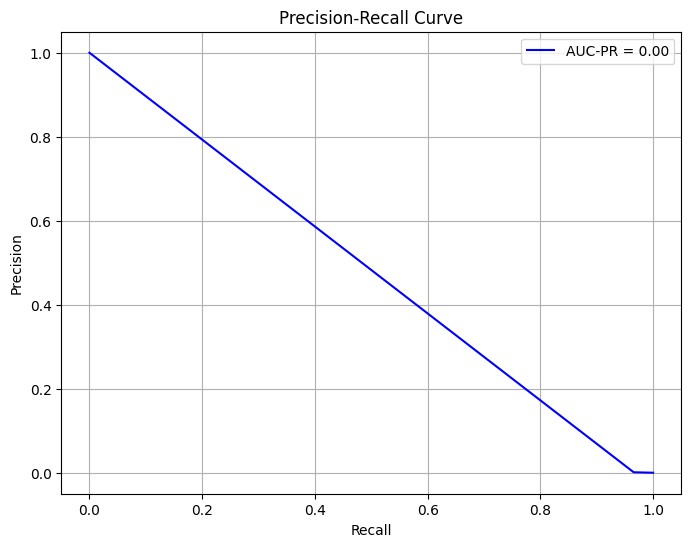

In [12]:
metrics.plot_auc_pr_curve(y_test, y_pred)

AUC-PR is pretty high and it shows strong balance between precision and recall. 

In [13]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, recall_score, classification_report

# Define the model
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))
clf = LogisticRegression(class_weight=class_weights_dict, random_state=seed)

# Perform cross-validation
cross_val_metrics = metrics.cross_validation(X_train, y_train, scaler, smote, clf)

# Average metrics across folds
average_precision = np.mean([m['1']['precision'] for m in cross_val_metrics])
average_recall = np.mean([m['1']['recall'] for m in cross_val_metrics])
average_f1 = np.mean([m['1']['f1-score'] for m in cross_val_metrics])

print(f"Precision: {average_precision:.3f}, Recall: {average_recall:.3f}, F1-Score: {average_f1:.3f}")


Precision: 0.002, Recall: 0.910, F1-Score: 0.003


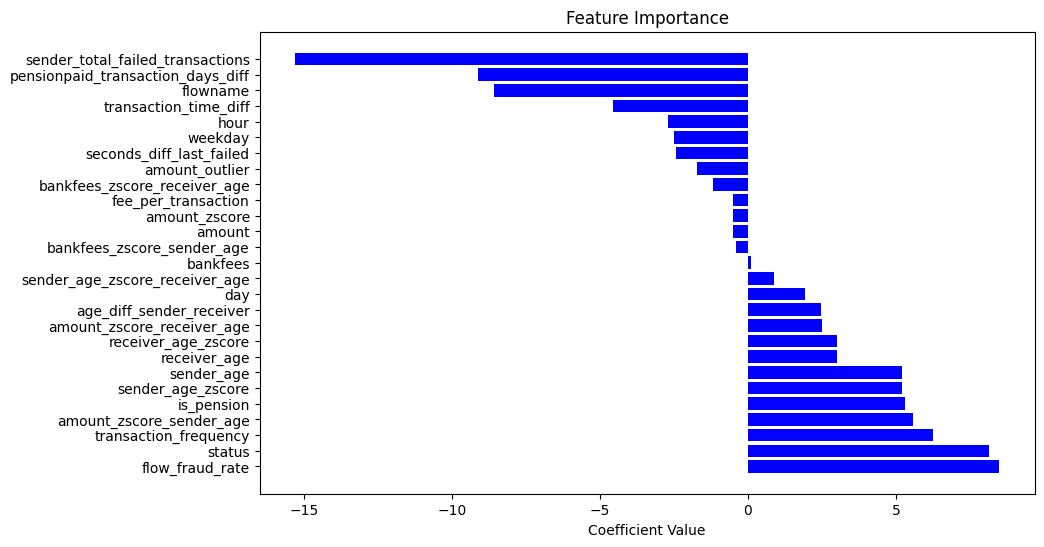

In [14]:
# show feature importance
feature_names = X.columns
coefficients = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": clf.coef_[0]
}).sort_values(by="Coefficient", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(coefficients['Feature'], coefficients['Coefficient'], color='blue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance')
plt.show()


As you see, new features that I have engineered contributed significantly to the decision-making process, e.g., day, hour, amount_outlier (especially, as we managed to identify 95% of fraudulent transactions based on this).  

Since we have 1 false negative, I will try to understand why the model is wrong here. Note that not only this model, but DT and XGB also made false negative on this one. What I can briefly say the transaction looks quite legitimate because:
- amount is very small, just 10. (Because of this, I hope this false negative does not cause significant impact to the business!)
- people were patient, as they waited pretty long to retry the failed transaction (64335 seconds) and between two transcations (64335.858552 seconds)
- they waited for quite a long time after receiving the pension money (23 days)

In [15]:
false_predictions = metrics.identify_false_predictions(path_to_data_orig, path_to_data_dev, y_test, y_pred)
false_predictions.T

,4,20,32,41,46,63,97,100,115,162,...,472308,472313,472314,472323,472324,472325,472332,472353,472361,472364
id,edab331e4013ba9c12e79d5524823b42,9201dea7af77f59ab6b00a56a32395c0,0fa77055cfc4ac0a6dd2fe41842e54fa,e33ecc4bbcd1831a673b1a63d2d6952b,c1c4fbd9102b1c43e108a78e78f419ef,319bf97202c4cf248b61cc2996a04047,041feade3edbd66c00fe55f902fdad4a,c6b2f008d76dc4e9676d095a81612892,5a435ba32d371bf1fdb71d11368828ee,beb53809e6ae54997330ff1d634b5af5,...,191949d36827d155e15743e6f3ea330c,3b4a2ab7c26d6160ca97ff17f8f2737b,33c9588d662157649ec7a880a5b1597e,4e1eb12a07255fea613babf25fa4050e,cea6bbfad14b63f92667d8c309888b01,2743e1d2e1323f626069047da96d3540,12dc5fa3bd26eac3be8ddaa803b0a75a,59a34bad8bb6b6a25c8795d0569d840b,d3564dfa036d2bfe285dbf53465eee08,e4b327445408cab4e1b5865f17eebc09
sender_id,80d33edb07155468a527ad5f698bb24c,01eb05236b7ba57dbce42138a50e354a,7f115f67dddcbd21de3425f59db95cc7,8359dfdc1bdc675b6c54307a43e8aa14,a7c500d1b99eaa5fdeff2204644417c6,e381c1637302b8b6609e1dd34127cb79,3247207432711352d5097b08258e8c42,34a0da634c41f7ca35073dbb23ef7316,2b1a6e7a8f429fdf498e9e70ea5bdcba,642c75dcfff89439140724120e3e6745,...,04f76b9b7d6c58cf08638067329df9ca,a36101d7e1c158d5a8124fb1aae70d3f,c92b719a10a32211d8b21f9fa64cfef9,667913c434402667b16727091b39129e,65f24fceb5cf14d2b45660fa959d84c3,13e9d9802a0a0666e00fe6d139696df1,dc6cf205f789c80985e2110afc822288,10b8a939c75fd0bca0047318b7fad95e,34d8038cea20e925f77bd2b7fbdfdd17,7cbce53e135f2192038f74890243d4d9
receiver_id,0601168e9e2f84e3188e8387b6e549bc,0d1c5f36db54df358fd65d79a93939ef,7a6d43aa92e5f1d06af3490a888decb6,7122c1599a7802b62d68c1f53aed6710,f326df32d6169d88725a66a253ba8208,02a1b81202d4fff75ba19035f85de8c0,c65fe067eb512be432ecfa649a66b33f,5b08528eb773247bf76ddeaa5bd3bf79,8a6a84fb127c18a7101996055c1ac593,f7b36ec24959ddc5d3e2ebb84dfb0f0f,...,0eb456707e60283d10d9c746ef5a68b3,ce34673f6e31e08081499fef6df5dec4,3ebb4d4d0ba710551133632eb64f826b,c5e1489b4da58b0a8df24813245bf53a,2cd1fa1c74903562c64077e11e9ac7bb,13c9e6fec53fac2f208337853100d3bb,d1ef08eb42dc9f0322626f99db9d6b8d,823cb0784c20daaee0bd02f187ea7179,072ec22c7c41af48219a0d3a111be3f9,b9dfdea6f3adf755c66b454dfbc76979
amount,5000.0,3000.0,1500.0,5000.0,1000.0,1000.0,5000.0,4693.5,9190.0,1000.0,...,743.0,300.0,1000.0,3500.0,5000.0,2000.0,400.0,300.0,150.0,500.0
status,PaymentSucceededV0,PaymentSucceededV0,PaymentSucceededV0,PaymentSucceededV0,PaymentSucceededV0,PaymentSucceededV0,PaymentSucceededV0,PaymentSucceededV0,PaymentSucceededV0,PaymentSucceededV0,...,PaymentSucceededV0,PaymentSucceededV0,PaymentSucceededV0,PaymentSucceededV0,PaymentSucceededV0,PaymentSucceededV0,PaymentSucceededV0,PaymentSucceededV0,PaymentSucceededV0,PaymentSucceededV0
flowname,233046f509c582591ff83d0915e07895,233046f509c582591ff83d0915e07895,06a380d2a2da7b3c0553297dd2b6c18c,06a380d2a2da7b3c0553297dd2b6c18c,06a380d2a2da7b3c0553297dd2b6c18c,06a380d2a2da7b3c0553297dd2b6c18c,06a380d2a2da7b3c0553297dd2b6c18c,06a380d2a2da7b3c0553297dd2b6c18c,6fed08d35288c5c3571085571e34c7c1,233046f509c582591ff83d0915e07895,...,233046f509c582591ff83d0915e07895,06a380d2a2da7b3c0553297dd2b6c18c,e395101288f53121cee2480bc7f24c4b,06a380d2a2da7b3c0553297dd2b6c18c,6e85ede9cf5197f7fa5f36a85a8a6adc,06a380d2a2da7b3c0553297dd2b6c18c,233046f509c582591ff83d0915e07895,06a380d2a2da7b3c0553297dd2b6c18c,06a380d2a2da7b3c0553297dd2b6c18c,233046f509c582591ff83d0915e07895
bankfees,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
timestamp,2024-05-13 07:44:03.693620+00:00,2024-05-13 07:44:15.554758+00:00,2024-05-13 07:44:22.415361+00:00,2024-05-13 07:44:32.265140+00:00,2024-05-13 07:44:36.557866+00:00,2024-05-13 07:44:54.622499+00:00,2024-05-13 07:45:20.998951+00:00,2024-05-13 07:45:26.160395+00:00,2024-05-13 07:45:40.805228+00:00,2024-05-13 07:46:20.113998+00:00,...,2024-05-18 08:18:25.879067+00:00,2024-05-18 08:18:27.803569+00:00,2024-05-18 08:18:27.820258+00:00,2024-05-18 08:18:29.788231+00:00,2024-05-18 08:18:29.966996+00:00,2024-05-18 08:18:30.077682+00:00,2024-05-18 08:18:32.315830+00:00

In [16]:
y_pred_proba = clf.predict_proba(X_test_standardized)
utils.generate_prediction_report(path_to_data_orig, path_to_data_dev, y_test, y_pred, y_pred_proba, 'results/lr_prediction_report.csv')

,id,sender_id,receiver_id,amount,status,flowname,bankfees,timestamp,sender_age,receiver_age,fraud,fraud_predicted,fraud_predicted_proba,fraud_rank
115,5a435ba32d371bf1fdb71d11368828ee,2b1a6e7a8f429fdf498e9e70ea5bdcba,8a6a84fb127c18a7101996055c1ac593,9190.0,PaymentSucceededV0,6fed08d35288c5c3571085571e34c7c1,0.0,2024-05-13 07:45:40.805228+00:00,47,51,0,1,1.0,1
402,e352e3b427f90d2f2df2b26eb0bb2033,f3dd0c8369ac90e3db27f0b0c93aa70b,af314e2356115fefaccef62ae66d8851,8500.0,PaymentSucceededV0,e395101288f53121cee2480bc7f24c4b,0.0,2024-05-13 07:49:36.264729+00:00,55,54,0,1,1.0,2
452,6494935a9347946cc85169f4884c4941,cc7954003dd7dd2363700a86fcb26acd,5daffbc7cbaa2dcc28329d1cc7804242,9215.0,PaymentSucceededV0,36628d303cdd443b0d1d475b58a76878,0.0,2024-05-13 07:50:10.723810+00:00,47,48,0,1,1.0,3
553,7592b960250c89d769991078bb04bd0b,ea9d896bd47f84cf34cb3ec6dfc4f9ea,f92b83a0ebd899e16c9fe92081bb0d78,15000.0,PaymentSucceededV0,233046f509c582591ff83d0915e07895,0.0,2024-05-13 07:51:29.291639+00:00,46,41,0,1,1.0,4
637,c2b56d88801f9edb94fc6a4febbfe19a,3f388d19e2fabefb82604146e7e92a1d,f084b73763d154be266c2585b9e1bec8,5000.0,PaymentSucceededV0,06a380d2a2da7b3c0553297dd2b6c18c,0.0,2024-05-13 07:52:39.780344+00:00,77,14,0,1,1.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143221,8b119c0e6c64c8d44e05cc3d5708f819,43b5a45e079439c3e589e33a3d265a5f,43b5a45e079439c3e589e33a3d265a5f,330.0,PaymentFailedV0,0b303e3880e0cd3a9f6033ee4b65cccc,0.0,2024-05-17 11:19:14.535627+00:00,21,21,0,0,0.0,472396
143222,8b119c0e6c64c8d44e05cc3d5708f819,43b5a45e079439c3e589e33a3d265a5f,43b5a45e079439c3e589e33a3d265a5f,330.0,PaymentFailedV0,0b303e3880e0cd3a9f6033ee4b65cccc,0.0,2024-05-17 11:31:41.384230+00:00,21,21,0,0,0.0,472397
270385,e84e878520f85e8a0a5a9887230332bf,43b5a45e079439c3e589e33a3d265a5f,43b5a45e079439c3e589e33a3d265a5f,100.0,PaymentFailedV0,0b303e3880e0cd3a9f6033ee4b65cccc,0.0,2024-05-17 15:20:36.557329+00:00,21,21,0,0,0.0,472398
414496,8cf1ef43800f1de064c5c4ab0c3481df,6e2ec7eb565f7bbade4a926a5fb9d451,f8adb281091423ed5299898811cedead,2000.0,PaymentFailedV0,e395101288f53121cee2480bc7f24c4b,0.0,2024-05-17 21:12:10.600138+00:00,24,22,0,0,0.0,472399


In [17]:
model_path = 'results/lr_model.pkl'
utils.save_model(clf, model_path)

## Decision Tree

In [18]:
model_name = 'dt'

F1: 0.9473684210526316
AUC ROC : 0.9655161797721219
AUC PR: 0.8977874973988303
Sensitivity (Recall): 0.9310344827586207
Specificity: 0.9999978767856232


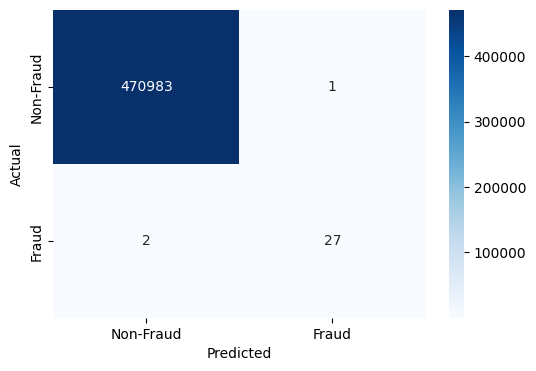

array([[470983,      1],
       [     2,     27]])

In [19]:
from sklearn.tree import DecisionTreeClassifier

# Training Decision Tree
clf = DecisionTreeClassifier(random_state=seed)
clf.fit(X_train_balanced, y_train_balanced)

# Evaluate Decision Tree
y_pred = clf.predict(X_test_standardized)
print("F1:", metrics.calc_f1(y_test, y_pred))
print("AUC ROC :", metrics.calc_auc_roc(y_test, y_pred))
print("AUC PR:", metrics.calc_auc_pr(y_test, y_pred))
print("Sensitivity (Recall):", metrics.calc_sensitivity(y_test, y_pred))
print("Specificity:", metrics.calc_specificity(y_test, y_pred))
metrics.generate_confusion_matrix(y_test, y_pred, 'results/' + model_name + '_confusion_matrix.png')


You also see that the performance of DT is a bit worse than that of LR, but it is still fine. DT has 2 false positives together with 1 false negative (same as LR and XGB). I think it yields pretty good performance.

I also tried to perform K-fold cross validation to check overfitting problem and nothing happened. 

*Update after test:*

The performance of DT degrades a little but not that much. Now it is better than that of LR.

In [20]:
# Define the model
clf = DecisionTreeClassifier(random_state=seed)

# Prepare for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
cross_val_metrics = []

# Perform cross-validation
cross_val_metrics = metrics.cross_validation(X_train, y_train, scaler, smote, clf)

# Average metrics across folds
average_precision = np.mean([m['1']['precision'] for m in cross_val_metrics])
average_recall = np.mean([m['1']['recall'] for m in cross_val_metrics])
average_f1 = np.mean([m['1']['f1-score'] for m in cross_val_metrics])

print(f"Precision: {average_precision:.3f}, Recall: {average_recall:.3f}, F1-Score: {average_f1:.3f}")


Precision: 0.896, Recall: 0.956, F1-Score: 0.923


In [21]:
false_predictions = metrics.identify_false_predictions(path_to_data_orig, path_to_data_dev, y_test, y_pred)
false_predictions.T

,60773,90003,472396
id,4f42a345127690807c606a78465eb67b,d8c4451a1712cc69554b1fb01d788251,d790ee6210c359f32dfdb3d00b751efb
sender_id,547a0fad90c756786ce615aaf93eddca,14879878a0883f0e548bb74998f9d892,391e8609f6b62b2f0ea88e1a5f95428c
receiver_id,2183aa1e1e7704e554dce16b28820804,9a0e8454c14e4bcfe2c3d51beb0600f3,d548d56705a5d6b05bd17cb76e6885ba
amount,1963.0,10.0,2799.0
status,PaymentSucceededV0,PaymentSucceededV0,PaymentSucceededV0
flowname,06a380d2a2da7b3c0553297dd2b6c18c,e395101288f53121cee2480bc7f24c4b,06a380d2a2da7b3c0553297dd2b6c18c
bankfees,0.0,0.0,0.0
timestamp,2024-05-13 18:27:53.897891+00:00,2024-05-14 10:24:03.738444+00:00,2024-06-07 09:58:11.504662+00:00
sender_age,68,71,83
receiver_age,37,68,54


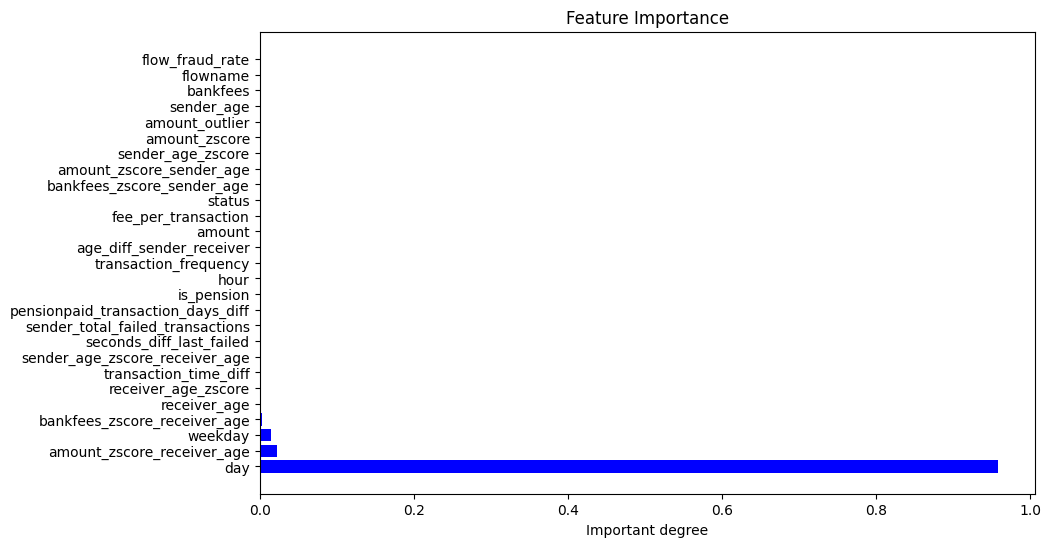

In [22]:
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': clf.feature_importances_
})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='blue')
plt.xlabel('Important degree')
plt.title('Feature Importance')
plt.show()


In this model, you see the amount_outlier feature is the most important feature of this model. And what I like about DT is it can interpret the results very well!

In [23]:
from sklearn.tree import export_text
rules = export_text(clf, feature_names=list(X.columns))
print(rules)

|--- day <= 1.05
|   |--- day <= -2.11
|   |   |--- class: 1
|   |--- day >  -2.11
|   |   |--- amount_zscore_receiver_age <= 4.40
|   |   |   |--- receiver_age <= 2.64
|   |   |   |   |--- transaction_time_diff <= -0.07
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- transaction_time_diff >  -0.07
|   |   |   |   |   |--- weekday <= 0.10
|   |   |   |   |   |   |--- weekday <= -0.84
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- weekday >  -0.84
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- weekday >  0.10
|   |   |   |   |   |   |--- class: 0
|   |   |   |--- receiver_age >  2.64
|   |   |   |   |--- bankfees_zscore_receiver_age <= -0.03
|   |   |   |   |   |--- receiver_age_zscore <= 3.01
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- receiver_age_zscore >  3.01
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- bankfees_zscore_receiver_age >  -0.03
|   |   |   |   |   |--- class: 0
|   |   |--- amount_zscor

In [24]:
y_pred_proba = clf.predict_proba(X_test_standardized)
utils.generate_prediction_report(path_to_data_orig, path_to_data_dev, y_test, y_pred, y_pred_proba, 'results/dt_prediction_report.csv')

,id,sender_id,receiver_id,amount,status,flowname,bankfees,timestamp,sender_age,receiver_age,fraud,fraud_predicted,fraud_predicted_proba,fraud_rank
472372,9eeefaebde4c6e0ae2b7f0c133525593,a8d88604449da4bbe0b318923b6d860e,68a1ba743df5ea66c42e2e4337d7127a,4900.00,PaymentSucceededV0,e395101288f53121cee2480bc7f24c4b,0.0,2024-05-22 17:43:04.655869+00:00,76,40,1,1,1.0,1
472373,4e5ddea07cfb6f95d2c563aad2f14dfe,a8d88604449da4bbe0b318923b6d860e,68a1ba743df5ea66c42e2e4337d7127a,900.00,PaymentSucceededV0,e395101288f53121cee2480bc7f24c4b,0.0,2024-05-22 17:47:18.754366+00:00,76,40,1,1,1.0,2
472374,6dacd6040b4926ad3d47c950484bf0ec,a8d88604449da4bbe0b318923b6d860e,68a1ba743df5ea66c42e2e4337d7127a,900.00,PaymentSucceededV0,e395101288f53121cee2480bc7f24c4b,0.0,2024-05-22 18:14:09.962350+00:00,76,40,1,1,1.0,3
472375,9ede7dcdaee017df75b46f384f532790,a8d88604449da4bbe0b318923b6d860e,68a1ba743df5ea66c42e2e4337d7127a,900.00,PaymentSucceededV0,e395101288f53121cee2480bc7f24c4b,0.0,2024-05-22 18:15:10.530202+00:00,76,40,1,1,1.0,4
472376,e5ea6aabe82cde9ef4193d3897d03804,a8d88604449da4bbe0b318923b6d860e,68a1ba743df5ea66c42e2e4337d7127a,900.00,PaymentSucceededV0,e395101288f53121cee2480bc7f24c4b,0.0,2024-05-22 18:17:45.307071+00:00,76,40,1,1,1.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
472367,7647dad68488845f7abe6313f3db0925,5df7d6c1dd2e8353061f4c7cbf09f868,14accebb53a2d485f177463ea6d1974a,315.00,PaymentSucceededV0,6fed08d35288c5c3571085571e34c7c1,0.0,2024-05-18 08:18:42.480895+00:00,17,17,0,0,0.0,472396
472368,7753eeb533e02ee189895dad09865ca0,bae7a0bcd48054ca11d3ba53ee9ab7f2,a76ac11c43bd1ff143a5e634f7aea54d,93.00,PaymentSucceededV0,6fed08d35288c5c3571085571e34c7c1,0.0,2024-05-18 08:18:42.529040+00:00,73,73,0,0,0.0,472397
472369,4a7895902556893da4b909734aecc1db,a507572605dac92688c859be70738d33,63523bab2212d6e8afcf75e11ca80c21,175.00,PaymentSucceededV0,06a380d2a2da7b3c0553297dd2b6c18c,0.0,2024-05-18 08:18:42.641938+00:00,29,29,0,0,0.0,472398
472370,0dab494e03d25a95886e9ac36a45c40a,563cb96b00a25e48f68eb3f93fb2d06a,20b5180a4d8b82a3eb211458fc419713,200.00,PaymentSucceededV0,6fed08d35288c5c3571085571e34c7c1,0.0,2024-05-18 08:18:43.747852+00:00,47,19,0,0,0.0,472399


In [25]:
model_path = 'results/dt_model.pkl'
utils.save_model(clf, model_path)

## XGBoosting

In [26]:
model_name = 'xgb'

*Update after test:*

Compare to the development phase, I introduced the balancing of class weights to XGB and change eval metric. It yields better results at the test phase.

In [27]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train_balanced, label=y_train_balanced, feature_names=X_train.columns.tolist())
dtest = xgb.DMatrix(X_test_standardized, label=y_test, feature_names=X_train.columns.tolist())

num_negatives = (y_train_balanced == 0).sum()
num_positives = (y_train_balanced == 1).sum()

scale_pos_weight = num_negatives / num_positives

params = {
    "objective": "binary:logistic",  # For classification
    'eval_metric': 'aucpr',
    'scale_pos_weight': scale_pos_weight
}

watchlist = [(dtrain, "train"), (dtest, "eval")]
num_rounds = 100
model = xgb.train(params, dtrain, num_rounds, watchlist, early_stopping_rounds=10)

y_pred_proba = model.predict(dtest)
y_pred = (y_pred_proba > 0.5).astype(int)  

[0]	train-aucpr:0.99935	eval-aucpr:0.07025
[1]	train-aucpr:0.99926	eval-aucpr:0.07608
[2]	train-aucpr:0.99937	eval-aucpr:0.07831
[3]	train-aucpr:0.99943	eval-aucpr:0.08498
[4]	train-aucpr:0.99946	eval-aucpr:0.08718
[5]	train-aucpr:0.99946	eval-aucpr:0.08927
[6]	train-aucpr:0.99946	eval-aucpr:0.09002
[7]	train-aucpr:0.99997	eval-aucpr:0.70429
[8]	train-aucpr:1.00000	eval-aucpr:0.89874
[9]	train-aucpr:1.00000	eval-aucpr:0.91672
[10]	train-aucpr:1.00000	eval-aucpr:0.94172
[11]	train-aucpr:1.00000	eval-aucpr:0.95339
[12]	train-aucpr:1.00000	eval-aucpr:0.96067
[13]	train-aucpr:1.00000	eval-aucpr:0.96319
[14]	train-aucpr:1.00000	eval-aucpr:0.96450
[15]	train-aucpr:1.00000	eval-aucpr:0.96569
[16]	train-aucpr:1.00000	eval-aucpr:0.96568
[17]	train-aucpr:1.00000	eval-aucpr:0.96585
[18]	train-aucpr:1.00000	eval-aucpr:0.96585
[19]	train-aucpr:1.00000	eval-aucpr:0.96585
[20]	train-aucpr:1.00000	eval-aucpr:0.96585
[21]	train-aucpr:1.00000	eval-aucpr:0.96585
[22]	train-aucpr:1.00000	eval-aucpr:0.9658

F1: 0.9824561403508771
AUC ROC : 0.9827586206896552
AUC PR: 0.965519364462962
Sensitivity (Recall): 0.9655172413793104
Specificity: 1.0


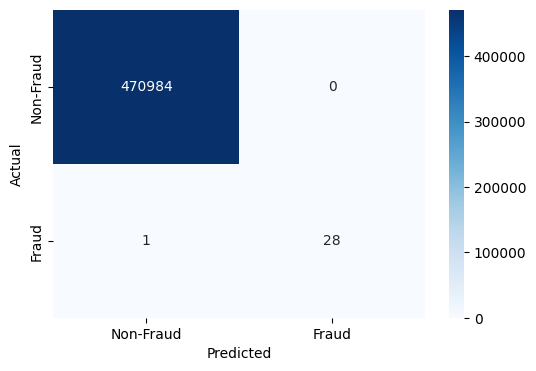

array([[470984,      0],
       [     1,     28]])

In [28]:
# Evaluate XGBoosting
print("F1:", metrics.calc_f1(y_test, y_pred))
print("AUC ROC :", metrics.calc_auc_roc(y_test, y_pred))
print("AUC PR:", metrics.calc_auc_pr(y_test, y_pred))
print("Sensitivity (Recall):", metrics.calc_sensitivity(y_test, y_pred))
print("Specificity:", metrics.calc_specificity(y_test, y_pred))
metrics.generate_confusion_matrix(y_test, y_pred, 'results/xgb_confusion_matrix.png')


The performance is similar to LR

In [29]:
# Define custom evaluation function for recall
def recall_eval(preds, dtrain):
    labels = dtrain.get_label()
    preds_binary = (preds > 0.5).astype(int)  
    recall = recall_score(labels, preds_binary)
    return 'recall', recall

# Perform cross-validation 
xgb_cv = xgb.cv(
    dtrain=dtrain,
    params=params,
    nfold=5,
    seed=seed,
    feval=recall_eval,
    maximize=True  
)

xgb_cv.mean()

train-aucpr-mean     0.999574
train-aucpr-std      0.000014
test-aucpr-mean      0.999571
test-aucpr-std       0.000033
train-recall-mean    0.997271
train-recall-std     0.001016
test-recall-mean     0.997257
test-recall-std      0.001064
dtype: float64

In [30]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, recall_score, classification_report

# Prepare for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
cross_val_metrics = []

for train_index, val_index in skf.split(X_train, y_train):
    # Split data into training and validation sets
    X_train_k, X_val_k = X_train.to_numpy()[train_index], X_train.to_numpy()[val_index]
    y_train_k, y_val_k = y_train.to_numpy()[train_index], y_train.to_numpy()[val_index]

    # Standardize and balance the data
    X_train_k_standardized, X_val_k_standardized = scaler.transform(X_train_k), scaler.transform(X_val_k)
    X_train_k_balanced, y_train_k_balanced = smote.fit_resample(X_train_k_standardized, y_train_k)
    
    # Train and validate the model
    dtrain = xgb.DMatrix(X_train_k_balanced, label=y_train_k_balanced, feature_names=X_train.columns.tolist())
    dtest = xgb.DMatrix(X_val_k_standardized, label=y_val_k, feature_names=X_train.columns.tolist())
    params = {
        "objective": "binary:logistic",  # For classification
        "eval_metric": "logloss",       # Evaluation metric
    }    
    watchlist = [(dtrain, "train"), (dtest, "eval")]
    num_rounds = 100
    model = xgb.train(params, dtrain, num_rounds, watchlist, early_stopping_rounds=10, verbose_eval=False)    
    y_pred_proba_val_k = model.predict(dtest)
    y_pred_val_k = (y_pred_proba_val_k > 0.5).astype(int)  
    
    # Collect metrics
    report = classification_report(y_val_k, y_pred_val_k, output_dict=True)
    cross_val_metrics.append(report)

# Average metrics across folds
average_precision = np.mean([m['1']['precision'] for m in cross_val_metrics])
average_recall = np.mean([m['1']['recall'] for m in cross_val_metrics])
average_f1 = np.mean([m['1']['f1-score'] for m in cross_val_metrics])

print(f"Precision: {average_precision:.3f}, Recall: {average_recall:.3f}, F1-Score: {average_f1:.3f}")


Precision: 0.986, Recall: 0.957, F1-Score: 0.970


As you see, K-fold cross validation shows no sign of overfitting

In [31]:
false_predictions = metrics.identify_false_predictions(path_to_data_orig, path_to_data_dev, y_test, y_pred)
false_predictions.T

,90003
id,d8c4451a1712cc69554b1fb01d788251
sender_id,14879878a0883f0e548bb74998f9d892
receiver_id,9a0e8454c14e4bcfe2c3d51beb0600f3
amount,10.0
status,PaymentSucceededV0
flowname,e395101288f53121cee2480bc7f24c4b
bankfees,0.0
timestamp,2024-05-14 10:24:03.738444+00:00
sender_age,71
receiver_age,68


This model also had the same performance with that of LR and made the same false negative to LR and DT. It makes me pretty confident that we do not have overfitting issue anywhere and the careful feature engineering process paid off!

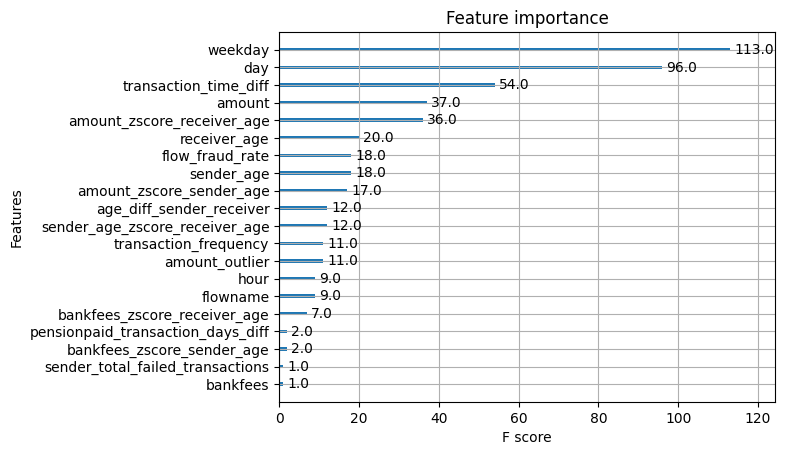

In [32]:
xgb.plot_importance(model)
plt.show()


Again, you see that day and amount_outlier are very important features.

In [33]:
y_pred_proba = y_pred_proba.reshape((-1, 1))
y_pred_proba = np.hstack([np.zeros((y_pred_proba.shape[0], 1)), y_pred_proba])
utils.generate_prediction_report(path_to_data_orig, path_to_data_dev, y_test, y_pred, y_pred_proba, 'results/xgb_prediction_report.csv')

,id,sender_id,receiver_id,amount,status,flowname,bankfees,timestamp,sender_age,receiver_age,fraud,fraud_predicted,fraud_predicted_proba,fraud_rank
472372,9eeefaebde4c6e0ae2b7f0c133525593,a8d88604449da4bbe0b318923b6d860e,68a1ba743df5ea66c42e2e4337d7127a,4900.0,PaymentSucceededV0,e395101288f53121cee2480bc7f24c4b,0.0,2024-05-22 17:43:04.655869+00:00,76,40,1,1,9.999995e-01,1
472373,4e5ddea07cfb6f95d2c563aad2f14dfe,a8d88604449da4bbe0b318923b6d860e,68a1ba743df5ea66c42e2e4337d7127a,900.0,PaymentSucceededV0,e395101288f53121cee2480bc7f24c4b,0.0,2024-05-22 17:47:18.754366+00:00,76,40,1,1,9.999995e-01,2
472374,6dacd6040b4926ad3d47c950484bf0ec,a8d88604449da4bbe0b318923b6d860e,68a1ba743df5ea66c42e2e4337d7127a,900.0,PaymentSucceededV0,e395101288f53121cee2480bc7f24c4b,0.0,2024-05-22 18:14:09.962350+00:00,76,40,1,1,9.999995e-01,3
472375,9ede7dcdaee017df75b46f384f532790,a8d88604449da4bbe0b318923b6d860e,68a1ba743df5ea66c42e2e4337d7127a,900.0,PaymentSucceededV0,e395101288f53121cee2480bc7f24c4b,0.0,2024-05-22 18:15:10.530202+00:00,76,40,1,1,9.999995e-01,4
472376,e5ea6aabe82cde9ef4193d3897d03804,a8d88604449da4bbe0b318923b6d860e,68a1ba743df5ea66c42e2e4337d7127a,900.0,PaymentSucceededV0,e395101288f53121cee2480bc7f24c4b,0.0,2024-05-22 18:17:45.307071+00:00,76,40,1,1,9.999995e-01,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274893,2bfa2c191b25b5a5f46a49e6891197a9,8c5b8b8348facba2db5b6c229e13b2d3,4f5a1d4bd6ce3f1d289f1763664a0e73,1250.0,PaymentSucceededV0,233046f509c582591ff83d0915e07895,0.0,2024-05-17 15:29:52.218158+00:00,23,18,0,0,2.172138e-07,472396
237903,71ee2b87832087bb2682c7dc03c5c2ae,9af086f8493cb3ad20092be291f1ba07,610cb2dc8662ba0f5b7a231ca9bfaa8e,1100.0,PaymentSucceededV0,6fed08d35288c5c3571085571e34c7c1,0.0,2024-05-17 14:15:08.433090+00:00,35,17,0,0,2.171877e-07,472397
146675,7c012fa7625823cb85da75a45c719727,ae39d6ac54b7e1412c38d572fcd58b03,ae39d6ac54b7e1412c38d572fcd58b03,1100.0,PaymentSucceededV0,0b303e3880e0cd3a9f6033ee4b65cccc,0.0,2024-05-17 11:25:00.750412+00:00,18,18,0,0,2.150646e-07,472398
104914,772f41c6a18605884aef835de66be998,538813c3730de606383f132d8f9201dd,6ef30cdceb3d2d8ed052d81f887bd4ce,1100.0,PaymentSucceededV0,6fed08d35288c5c3571085571e34c7c1,0.0,2024-05-17 10:31:57.962305+00:00,19,20,0,0,2.083674e-07,472399


In [34]:
model_path = 'results/xgb_model.pkl'
utils.save_model(model, model_path)

## KMeans

KMeans is used based on the motivation that legitimate transcations distributedly close to each other and the same for fradulent transactions.

KMeans, and you will see later - Isolation Forest and Gaussian Mixture - are unsupervised learning ML models. This approach is useful when we just have the data and we have not yet labelled it, which would be time-consuming.

In [35]:
model_name = 'kmeans'

In [36]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=seed)  # We assume 2 clusters: fraud and non-fraud
kmeans.fit(np.vstack([X_train_standardized, X_test_standardized]))
kmeans_labels = kmeans.labels_

# Compute the mean feature values for each cluster
cluster_means = pd.DataFrame(np.vstack([X_train_standardized, X_test_standardized])).groupby(kmeans_labels).mean()

# Based on the cluster means, map the cluster with higher values to 'fraud' (1) and the other to 'non-fraud' (0)
fraud_cluster = cluster_means.mean(axis=1).idxmax()  
y_pred = np.where(kmeans_labels == fraud_cluster, 1, 0) 

In [37]:
# Since we are performing unsupervised learning, we run KMeans on the whole data. 
# For test, we want to just extract the ones from test set.
y_pred = y_pred[-len(X_test_standardized):] 

F1: 0.0
AUC ROC : 0.49987260713739745
AUC PR: 6.156942589694977e-05
Sensitivity (Recall): 0.0
Specificity: 0.9997452142747949


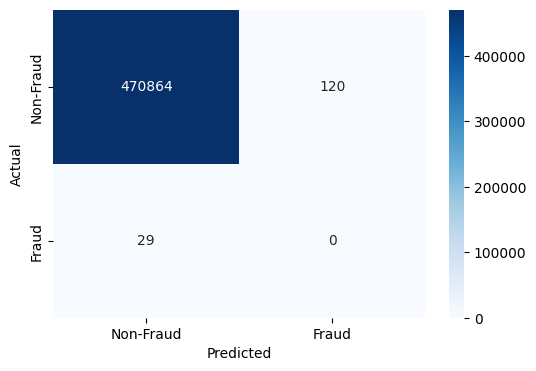

array([[470864,    120],
       [    29,      0]])

In [38]:
# Evaluate
print("F1:", metrics.calc_f1(y_test, y_pred))
print("AUC ROC :", metrics.calc_auc_roc(y_test, y_pred))
print("AUC PR:", metrics.calc_auc_pr(y_test, y_pred))
print("Sensitivity (Recall):", metrics.calc_sensitivity(y_test, y_pred))
print("Specificity:", metrics.calc_specificity(y_test, y_pred))
metrics.generate_confusion_matrix(y_test, y_pred, 'results/' + model_name + '_confusion_matrix.png')


Starting from here, we can see performance of unsupervised learning models are not good. Thus, I will not analyze the results any deeper.

## Isolation Forest

IF is popular anomaly detection model. Basically, fraudulent transcations are viewed as anomalies and we try to detect them.

In [39]:
model_name = 'if'

In [40]:
from sklearn.ensemble import IsolationForest

# Fit the model
model = IsolationForest(contamination=0.001)
model.fit(X_train_standardized)

# Predict anomalies
y_pred = model.predict(X_test)  # -1 for anomalies, 1 for normal 
y_pred[y_pred == -1] = 0

F1: 8.724709249064276e-06
AUC ROC : 0.04780274401297473
AUC PR: 5.762412966812472e-05
Sensitivity (Recall): 0.06896551724137931
Specificity: 0.026639970784570175


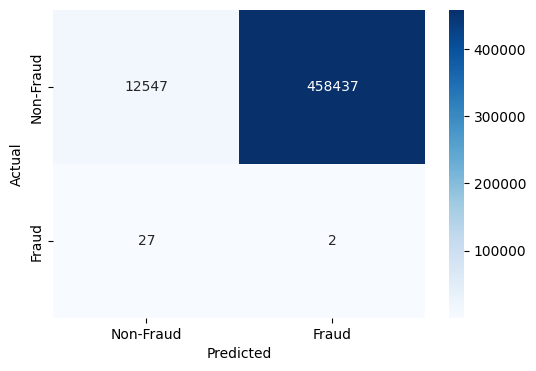

array([[ 12547, 458437],
       [    27,      2]])

In [41]:
# Evaluate 
print("F1:", metrics.calc_f1(y_test, y_pred))
print("AUC ROC :", metrics.calc_auc_roc(y_test, y_pred))
print("AUC PR:", metrics.calc_auc_pr(y_test, y_pred))
print("Sensitivity (Recall):", metrics.calc_sensitivity(y_test, y_pred))
print("Specificity:", metrics.calc_specificity(y_test, y_pred))
metrics.generate_confusion_matrix(y_test, y_pred, 'results/' + model_name + '_confusion_matrix.png')


Bad as KMeans. Another problem is we have to play with hyperparameters, in this case contamination rate. It is not easy to come up with the correct one. Furthermore, data can be changed over time, i.e., concept drift problem.

## GaussianMixture

GM is effective in identifying clusters having different data distributions. In this case, we would have two clusters: legitimate and fraudulent transactions. My assumption is these groups of clusters have very different data distributions. 

In [42]:
model_name = 'gaussian_mixture'

In [43]:
from sklearn.mixture import GaussianMixture

# Fit the model
model = GaussianMixture(n_components=2)
model.fit(X_train_standardized)

# Predict the log-likelihood of each point
log_likelihood = model.score_samples(X_test)


F1: 0.00012314381924185871
AUC ROC : 0.500050957145041
AUC PR: 6.157570095442336e-05
Sensitivity (Recall): 1.0
Specificity: 0.000101914290082041


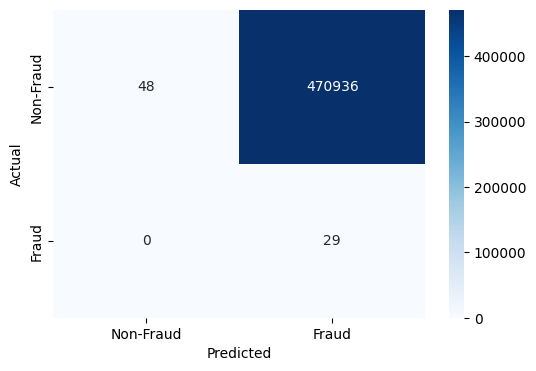

array([[    48, 470936],
       [     0,     29]])

In [44]:
# Flag anomalies based on log-likelihood
anomaly_threshold = np.percentile(log_likelihood, 0.01)  # this is not easy to come up with!
y_pred = (log_likelihood > anomaly_threshold).astype(int)

# Evaluate
print("F1:", metrics.calc_f1(y_test, y_pred))
print("AUC ROC :", metrics.calc_auc_roc(y_test, y_pred))
print("AUC PR:", metrics.calc_auc_pr(y_test, y_pred))
print("Sensitivity (Recall):", metrics.calc_sensitivity(y_test, y_pred))
print("Specificity:", metrics.calc_specificity(y_test, y_pred))
metrics.generate_confusion_matrix(y_test, y_pred, 'results/' + model_name + '_confusion_matrix.png')


This model is better than that of KMeans and IF, but it is still bad.

## AutoEncoder

AE is a semi-supervised learning deep learning model. AE is trained on normal data, which legitimate transcations in this case. Then, it is used to detect fraudulent transactions which are presumably different from the form in terms of data distribution. 

This approach is useful when we do have only legitimate transactions labelled.

In [45]:
model_name = 'ae'

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim

normal_data_scaled = X_train_standardized[y_train == 0]
unlabeled_data_scaled = X_test_standardized 

# Define the model
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Prepare data for training and init model
normal_data_tensor = torch.tensor(normal_data_scaled, dtype=torch.float32)
unlabeled_data_tensor = torch.tensor(unlabeled_data_scaled, dtype=torch.float32)
input_dim = normal_data_scaled.shape[1]
model = Autoencoder(input_dim=input_dim)
criterion = nn.MSELoss() # we use MSE as it is more robust to outliers
optimizer = optim.Adam(model.parameters())

# Train the model
num_epochs = 10
batch_size = 32
for epoch in range(num_epochs):
    model.train()
    permutation = torch.randperm(normal_data_tensor.size(0))
    epoch_loss = 0.0
    for i in range(0, normal_data_tensor.size(0), batch_size):
        indices = permutation[i:i+batch_size]
        batch = normal_data_tensor[indices]
        
        optimizer.zero_grad()
        reconstructed = model(batch)
        loss = criterion(reconstructed, batch)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss / len(normal_data_tensor):.4f}")

Epoch 1/10, Loss: 0.0021
Epoch 2/10, Loss: 0.0013
Epoch 3/10, Loss: 0.0010
Epoch 4/10, Loss: 0.0010
Epoch 5/10, Loss: 0.0008
Epoch 6/10, Loss: 0.0007
Epoch 7/10, Loss: 0.0008
Epoch 8/10, Loss: 0.0009
Epoch 9/10, Loss: 0.0007
Epoch 10/10, Loss: 0.0006


In [47]:
# We calculate anomaly score by checking reconstruction error, here MSE is used as it is more senstive to outliers
model.eval()
with torch.no_grad():
    reconstructed_unlabeled = model(unlabeled_data_tensor)
    reconstruction_errors = torch.mean((reconstructed_unlabeled - unlabeled_data_tensor) ** 2, dim=1).numpy()
    
# We have to play a bit with threshold, this is the best so far
threshold = np.percentile(reconstruction_errors, 99.9)  
y_pred = (reconstruction_errors > threshold).astype(int)

F1: 0.10778443113772455
AUC ROC : 0.9650448261804925
AUC PR: 0.05326257463019044
Sensitivity (Recall): 0.9310344827586207
Specificity: 0.9990551696023644


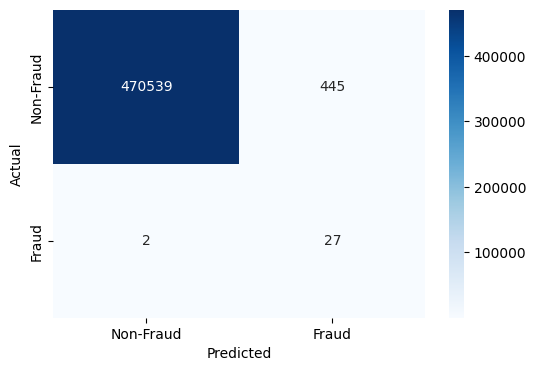

array([[470539,    445],
       [     2,     27]])

In [48]:
# Evaluate
print("F1:", metrics.calc_f1(y_test, y_pred))
print("AUC ROC :", metrics.calc_auc_roc(y_test, y_pred))
print("AUC PR:", metrics.calc_auc_pr(y_test, y_pred))
print("Sensitivity (Recall):", metrics.calc_sensitivity(y_test, y_pred))
print("Specificity:", metrics.calc_specificity(y_test, y_pred))
metrics.generate_confusion_matrix(y_test, y_pred, 'results/' + model_name + '_confusion_matrix.png')


As you see, the result here is a bit better than unsupervised learning models but still is not very satisfactory compared to supervised learning models. 

The problem with AE is there are many hyperparameters to optimize and it is not just anomaly score.